# Analysis of NYC Taxi Trip Data
### Patrick Cullinane June 2019

The NYC Taxi and Limousine Commission (TLC) collects data on such as pick-up/drop-off times, pick-up/drop-off locations, data on payment types, number of passengers, and passenger count amount other fields. TLC posts this information by month and year on the following website: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

The website provides a month-by-month breakdown of taxi data from yellow taxis, green taxis, and For-Hire Vehicles (FHV). FHV's consist of community cars, black cars, luxury limos, and high-volume for-hire services. Addtionally, the data is broken down by year and month. Because there is an enourmous amount of data we will start our analysis with yellow taxis in August of 2018.

In [1]:
#import necessary libraries

import os
import glob
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
#import taxi_functions as tf
import geopandas as gpd
from datetime import datetime
import matplotlib.dates as mdates
from scipy.stats import ttest_ind
%matplotlib inline

First of course is to import all the necessary libraries that will be needed during this process. Next I went ahead and downloaded all of 2018's data from the link above and moved it to a directory. Below is the code to process all the csv files in 2018.  

In [2]:
#grab data from file, process it, and make it ready to be turned into a dataframe

DATA_PATH = os.path.join(os.getcwd(),'data') #get the path to the data folder
files = glob.glob(DATA_PATH + '/*.csv') #find all files with .csv

date_names = [] #make an empty list

for i in range(len(files)):
    date_data = datetime.strptime(files[i][-11:-4], '%Y-%m') #turn year-mo into datetime
    name = date_data.strftime('%b') + str('_data') #name the file 'Mon_data'
    temp = {name:files[i]} #store it as a dictionary
    date_names.append(temp) #append it to a larger list of all the files
    
month_list = []

for i in range(len(date_names)):
    x = list(date_names[i].keys())[0] #make a list of just the month names
    month_list.append(x)
    
file_list = []

for i in range(len(date_names)):
    x = list(date_names[i].values())[0] #make a list of just the file names
    file_list.append(x)
    
for i in range(len(month_list)):    
    exec("%s=%a" % (month_list[i],file_list[i])) #iterate over list and turn into variables 
    
print('There are %d months in this data set' %len(month_list))

There are 12 months in this data set


The code above looks for all files with the .csv extension and creates individual files for each month in the format Mon_data. So for the month of August it will look like "Aug_data".

The TLC website also offers shape files for associating taxi trips with locations throughout the five boroughs. I loaded up all the necessary files below and created a dataframe that has the location id with zone name and borough. This will come in handy later on in this notebook.

Below are the shape files for the TLC taxi zones, and I picked out the month of August and turn the variable we created above into a dataframe named "Aug".

In [3]:
#load some map data for future use

taxi_map_shx = DATA_PATH + '/taxi_zones.shx'
taxi_map_shp = DATA_PATH + '/taxi_zones.shp'
taxi_map_dbf = DATA_PATH + '/taxi_zones.dbf'

map_df = gpd.read_file(taxi_map_shx, encoding='utf-8'); map_df.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ..."


In [4]:
#Turn august data into a dataframe and show the first 5 rows
Aug = pd.read_csv(Aug_data); Aug.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-08-01 00:44:35,2018-08-01 01:03:22,1,5.6,1,N,238,79,1,19.0,0.5,0.5,4.00,0.0,0.3,24.30
1,1,2018-08-01 00:02:19,2018-08-01 00:02:31,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80
2,1,2018-08-01 00:13:25,2018-08-01 00:24:40,1,2.9,1,N,138,7,1,11.5,0.5,0.5,2.55,0.0,0.3,15.35
3,1,2018-08-01 00:10:37,2018-08-01 00:49:10,1,8.4,1,N,231,7,1,30.0,0.5,0.5,7.80,0.0,0.3,39.10
4,1,2018-08-01 00:02:18,2018-08-01 00:07:32,2,0.7,1,N,79,148,1,5.5,0.5,0.5,0.00,0.0,0.3,6.80


In [5]:
#quick look at what the column names are and how much data I am working with 

count_row = Aug.shape[0]
count_col = Aug.shape[1]

print('there are %d rows' %count_row)
print('there are %d columns' %count_col)
print('')
print(Aug.dtypes)

there are 7849134 rows
there are 17 columns

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object


Every row represents a trip and there were 7,849,134 trips completed by yellow taxis in August. 

The 17 columns consist of the following data and data types:
1. VendorID: Categorical/Nominal data and represents the Taxicab Passenger Enhancements Program (TPEP) which is technology that allows passengers to pay for trips with credit cards, records trips, and allows the Taxi & Limo Commission (TLC) to communicate with drivers. Value is either 1 ( Creative Mobile Technologies) or 2 (VeriFone Inc.)
2. tpep_pickup_datetime: Discrete - The date and time when the meter was engaged. 
3. tpep_dropoff_datetime: Discrete - The date and time when the meter was disengaged.  
4. passenger_count: Discrete - The number of passengers in the vehicle as reported by the driver. 
5. trip_distance: Continuous - Distance in miles reported by the taximeter.
6. RatecodeID: Categorical/Nominal, a value 1-6 that represents the rate code in effect during the trip. 1=Standard rate, 2=JFK, 3=Newark, 4=Nassau or Weschester, 5=Negotiated Fare, 6=Group ride. 
7. store_and_fwd_flag: Categorical/Nominal- Categorical and represents if indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. Values are either Y=store and forward trip, or N=not a store and forward trip
8. PULocationID: Categorical/Nominal - corresponds to a TLC taxi zone with defined geometry.
9. DOLocationID: Categorical/Nominal - same as above
10. payment_type: Categorical/Nominal and shows values 1-6 depending on how the passenger paid for the trip. 1=Credit Card, 2=Cash, 3=No Charge, 4=Dispute, 5=Unknown, 6=Voided Trip.
11. fare_amount: Numerical/Continuous - Time and distance fare calculated by the meter. 
12. extra: Numerical/Discrete - Misc and extra charges which are $0.50 charge, $1 rush hour, or overnight charge.
13. mta_tax: Numerical/Discrete - $0.50 MTA tax triggered by based on meter rate in use.
14. tip_amount: Numerical/Continuous - For credit card tips, cash is not included.
15. tolls_amount: Numerical/Discrete - Total amount paid in tolls on trip
16. improvement_surcharge: Numerical/Discrete
17. total_amount: Numerical/Continuous Total amount charged to the passenger


I will start the analysis by analyzing passenger_count. Let's see how many of each value (# of passengers) exist and how frequently those values appear. First I am going to make a dataframe with each possible value and the frequency at which it appears. Then I will apply that dataframe to a bar chart.

In [6]:
passenger_count_df = pd.DataFrame(Aug['passenger_count'].value_counts())
passenger_count_df = passenger_count_df.reset_index()
passenger_count_df.columns.values[0] = '# of passengers'
passenger_count_df.columns.values[1] = '# of trips'

passenger_count_df

,# of passengers,# of trips
0,1,5571608
1,2,1142587
2,5,350760
3,3,337346
4,6,213453
5,4,167897
6,0,65409
7,7,32
8,8,22
9,9,20


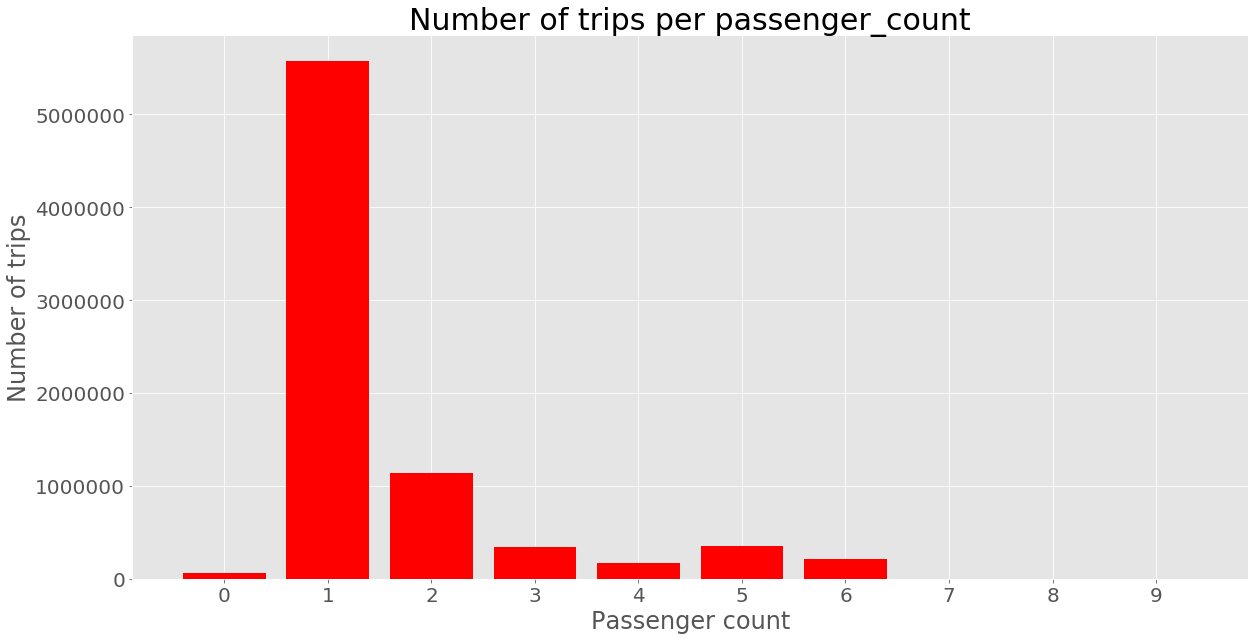

In [72]:
fig, ax = plt.subplots(1, figsize=(20,10))

plt.bar(passenger_count_df['# of passengers'], passenger_count_df['# of trips'], color='r')
plt.ylabel('Number of trips')
plt.xlabel('Passenger count')
plt.xticks(np.arange(0, 10, step=1))
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})
ax.set_title('Number of trips per passenger_count', fontdict={'fontsize': '30', 'fontweight' : '3'})
plt.show()

The number of 1 & 2 person taxi rides make up the majority of the rides. According to the data the max number of riders was nine. This is hard to imagine in a yellow taxi, as the most that I've seen fit in a cab is five. Does this value represent young children sitting on laps? NYC taxi drivers are known to do crazier things though. A quick google search provides no answers, but some of these results maybe a result of driver error as this a driver entered paramenter. Perhaps passenger counts greater than 6 maybe unreliable and maybe due to driver error.

Another data point that easily jumps out is the 65,409 trips that recorded zero passengers. Is this a result of driver error, or were the trips voided? One way we can investigate this more is to evaluate what the payment type was for trips that carried zero passengers.

In [8]:
Aug[Aug['passenger_count']==0]['payment_type'].value_counts()

1    43838
2    20264
3     1039
4      268
Name: payment_type, dtype: int64

Of the trips where zero passengers were recorded the majority of payment types were either credit card (1) or cash (2). The rest were either no charge (3) or dispute (4). With the bulk of the payment types either cash or credit it looks like the driver could have made an error entering the number of passengers. With that said it is easy to hypothesize that at least some of the driver-reported data is unreliable based on this info above.

# Pick-ups and Drop-offs by location

The next category that we will look into is the pick-up locations and drop-off locations. In the TLC dataset the location ID is a categorical value that represents a zone. From the map data we loaded earlier we can see that each location ID is associated with a zone name, a borough, and shape data that makes up the zone geometry.

I will merge the pick-up and drop-off data with the map data to get value counts for each location. I will then turn that data into a heatmap so we can better visualize areas of interest.

In [9]:
map_df.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ..."


In [10]:
#create pickup and dropoff dataframes with value counts per location
pickups = Aug['PULocationID'].value_counts() #count the number of pickups
dropoffs = Aug['DOLocationID'].value_counts()
pickups_df = pd.DataFrame(pickups) #turn into a dataframe
dropoff_df = pd.DataFrame(dropoffs)
pickups_df['LocationID'] = pickups_df.index 
dropoff_df['LocationID'] = dropoff_df.index
merged_pu = pd.merge(map_df,pickups_df,on=['LocationID']) #merge on LocationID
merged_do = pd.merge(map_df,dropoff_df,on=['LocationID']); merged_do.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,DOLocationID
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",14618
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",5
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",640
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",36076
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",60


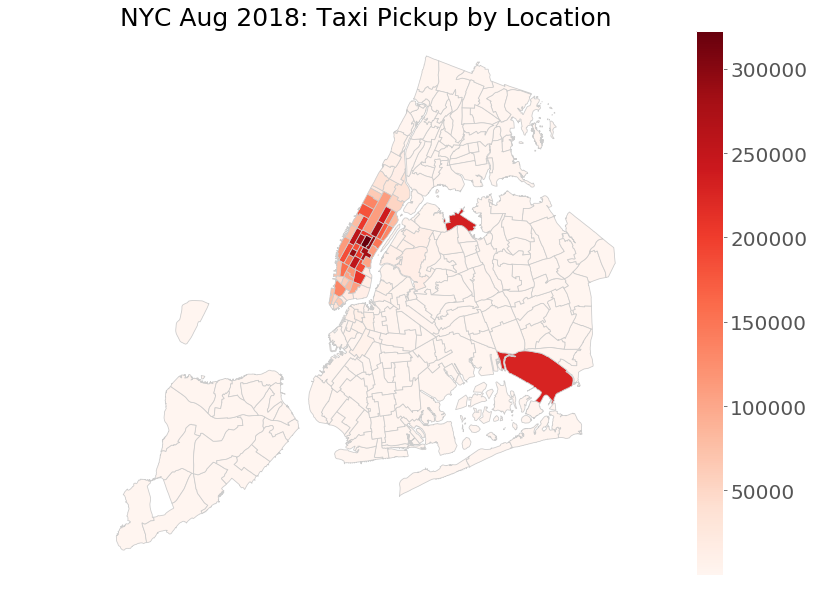

In [11]:
fig, ax = plt.subplots(1, figsize=(20,10))
merged_pu.plot(column='PULocationID', ax=ax, cmap='Reds', linewidth=0.8, edgecolor='0.8', legend=True)
ax.set_title('NYC Aug 2018: Taxi Pickup by Location', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.axis('off')
plt.show()

Let's visualize what the top 20 pick-up spots look like in a bar chart

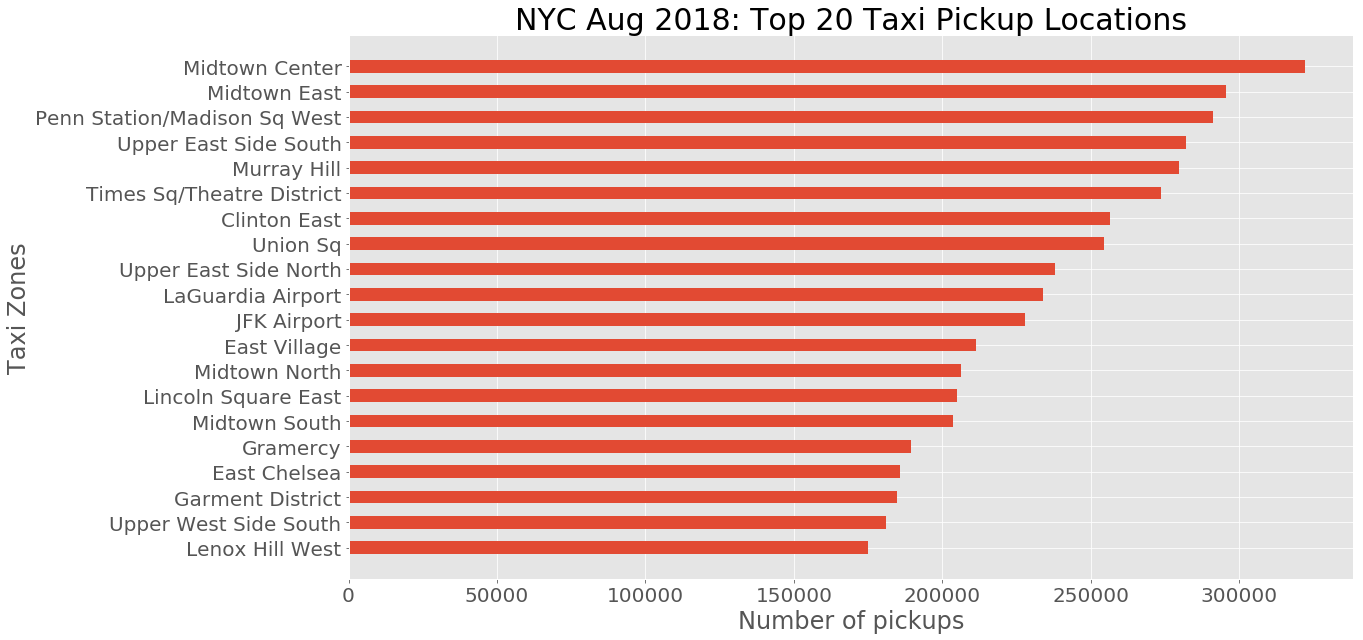

In [12]:
#top 20 pickup locations visualized

largest_pu = merged_pu.nlargest(20, ['PULocationID'])
f, ax = plt.subplots(figsize=(18,10))
plt.barh(largest_pu['zone'],largest_pu['PULocationID'],height=.5)
plt.gca().invert_yaxis()
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})
ax.set_title('NYC Aug 2018: Top 20 Taxi Pickup Locations', fontdict={'fontsize': '30', 'fontweight' : '3'})
plt.ylabel('Taxi Zones')
plt.xlabel('Number of pickups')


plt.show()

Next let's do the same thing with the drop-offs

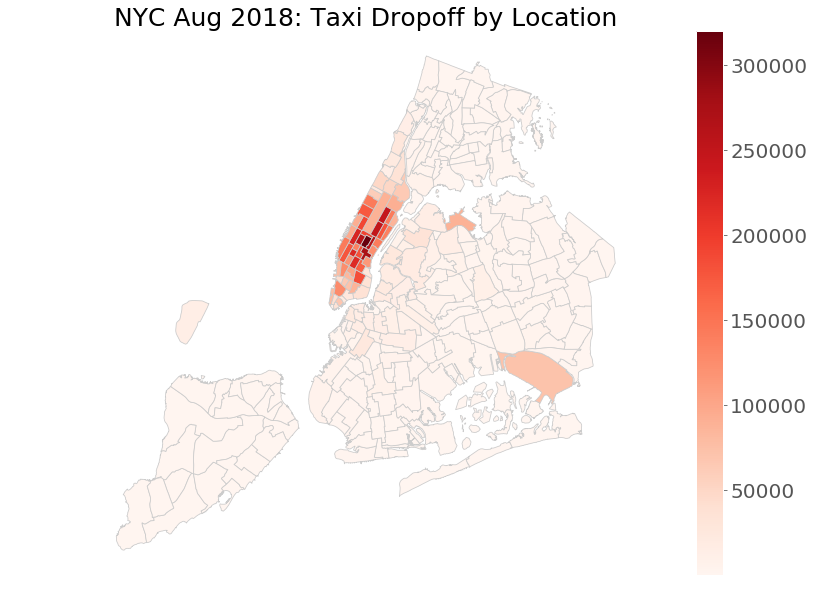

In [13]:
fig, ax = plt.subplots(1, figsize=(20,10))
merged_do.plot(column='DOLocationID', ax=ax, cmap='Reds', linewidth=0.8, edgecolor='0.8', legend=True)
ax.set_title('NYC Aug 2018: Taxi Dropoff by Location', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.axis('off')
plt.show()

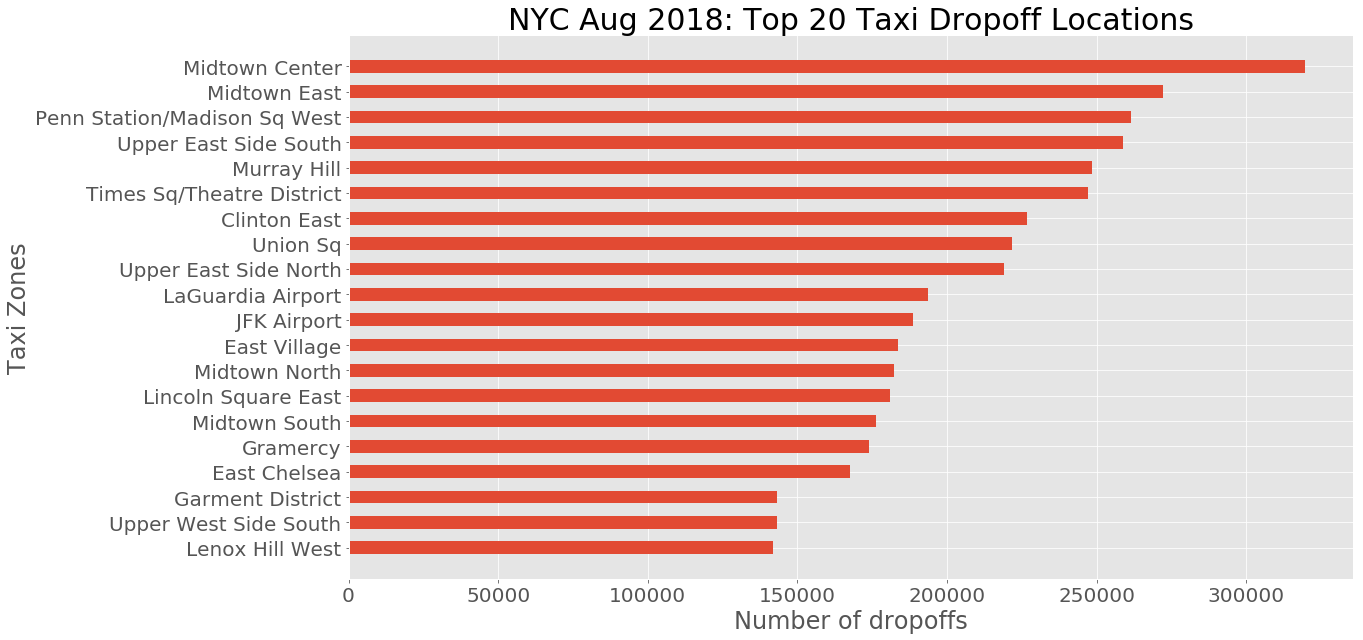

In [14]:
largest_do = merged_do.nlargest(20, ['DOLocationID'])
f, ax = plt.subplots(figsize=(18,10))
plt.barh(largest_pu['zone'],largest_do['DOLocationID'],height=.5)
plt.gca().invert_yaxis()
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})
ax.set_title('NYC Aug 2018: Top 20 Taxi Dropoff Locations', fontdict={'fontsize': '30', 'fontweight' : '3'})
plt.ylabel('Taxi Zones')
plt.xlabel('Number of dropoffs')


plt.show()

With the exception of the airports most of our yellow taxi trips are occuring within Manhattan. Let's do a side by side comparison of pick-ups and drop-offs zoomed in on Manhattan to understand the data alot better.

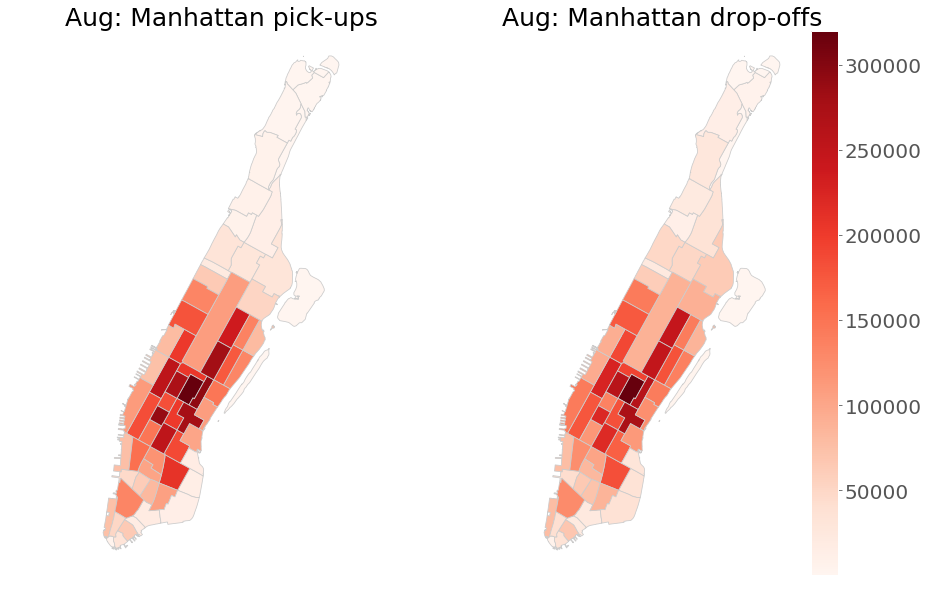

In [15]:
manhattan_pu = merged_pu.loc[merged_pu['borough'] == 'Manhattan'] #sort by only Manhattan trips
manhattan_do = merged_do.loc[merged_do['borough'] == 'Manhattan']

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(15,10))

manhattan_pu.plot(ax=ax1, column='PULocationID', cmap='Reds', linewidth=0.8, edgecolor='0.8')
manhattan_do.plot(ax=ax2, column='DOLocationID', cmap='Reds', linewidth=0.8, edgecolor='0.8', legend=True)
ax1.axis('off')
ax1.set_title('Aug: Manhattan pick-ups', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax2.axis('off')
ax2.set_title('Aug: Manhattan drop-offs', fontdict={'fontsize': '25', 'fontweight' : '3'})
plt.show()

# Exploring trips by time of day

Do the number of trips made fluctuate by time of day? In order to do this I need to convert the time data in the set to datetime format. I will then create a dataframe with the pickup datetimes as the index. This will allow me to plot the data and see if there are any patterns.

In [16]:
#convert pick-up and drop-off to datetime 

Aug['tpep_pickup_datetime'] = pd.to_datetime(Aug.tpep_pickup_datetime) 
Aug['tpep_dropoff_datetime'] = pd.to_datetime(Aug.tpep_dropoff_datetime)

Aug.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
dtype: object

In [17]:
#reindex the dataframe by making the index the tpep-pickup datetime
Aug_pickup = Aug
Aug_pickup.index = Aug_pickup['tpep_pickup_datetime']
Aug_pickup.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
tpep_pickup_datetime,,,,,,,,,,,,,,,,,
2018-08-01 00:44:35,1,2018-08-01 00:44:35,2018-08-01 01:03:22,1,5.6,1,N,238,79,1,19.0,0.5,0.5,4.00,0.0,0.3,24.30
2018-08-01 00:02:19,1,2018-08-01 00:02:19,2018-08-01 00:02:31,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80
2018-08-01 00:13:25,1,2018-08-01 00:13:25,2018-08-01 00:24:40,1,2.9,1,N,138,7,1,11.5,0.5,0.5,2.55,0.0,0.3,15.35
2018-08-01 00:10:37,1,2018-08-01 00:10:37,2018-08-01 00:49:10,1,8.4,1,N,231,7,1,30.0,0.5,0.5,7.80,0.0,0.3,39.10
2018-08-01 00:02:18,1,2018-08-01 00:02:18,2018-08-01 00:07:32,2,0.7,1,N,79,148,1,5.5,0.5,0.5,0.00,0.0,0.3,6.80


What I am doing below is assigning each row a value of 1 so I can count the number of trips that occur in certain times throughout the day. I will then plot the data on a monthly, weekly, and hourly basis to see if any patterns emerge.

In [18]:
#make a dummy value = 1 to represent a trip and create a dataframe with just the date index in value so we can
#visualize how the pickups are dispersed

Aug_pickup['dummy_value'] = 1
Aug_pickup_df = pd.DataFrame(Aug_pickup['dummy_value'])
Aug_pickup_df.head()

,dummy_value
tpep_pickup_datetime,
2018-08-01 00:44:35,1
2018-08-01 00:02:19,1
2018-08-01 00:13:25,1
2018-08-01 00:10:37,1
2018-08-01 00:02:18,1


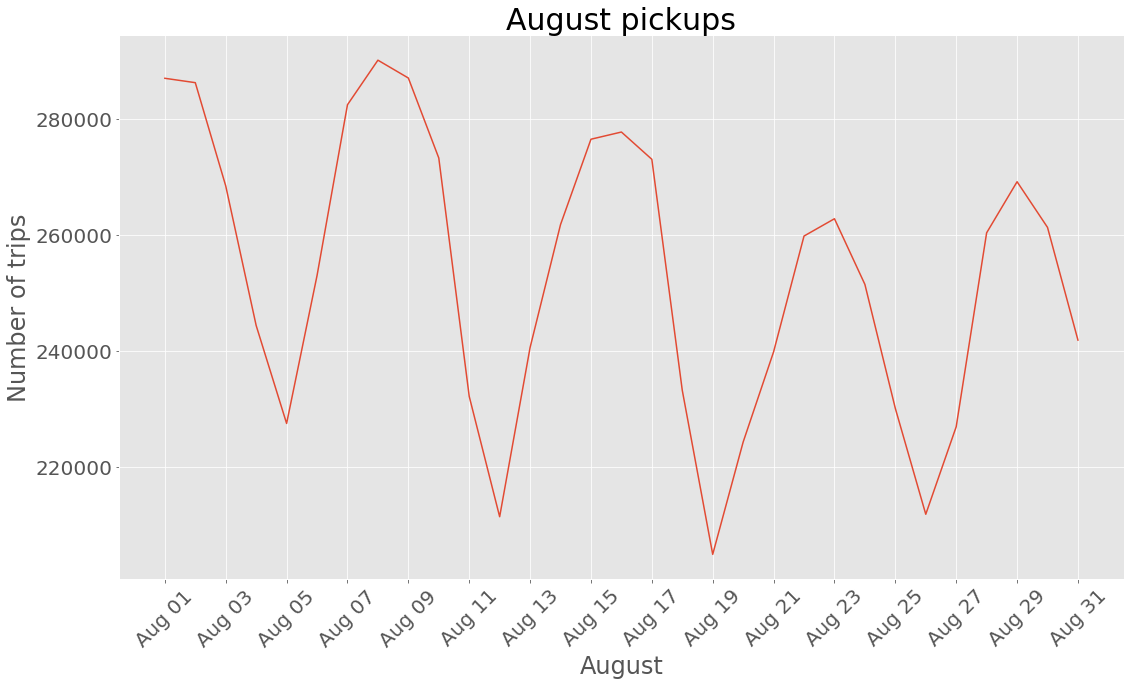

In [19]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

daily = Aug_pickup_df.resample('D').sum()
f, ax = plt.subplots(figsize=(18,10))
plt.plot(daily['2018-08'])
plt.rcParams.update({'font.size': 20})
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_title('August pickups', fontdict={'fontsize': '30', 'fontweight' : '3'})
plt.xticks(rotation=45)
plt.ylabel('Number of trips')
plt.xlabel('August')
plt.show()

There appears to be a trend of peaks and valleys throughout the month. It looks like overall the taxis are busiest during the week and die down on the weekends. Let's look at one week's worth of data to get a better idea of the daily trends.

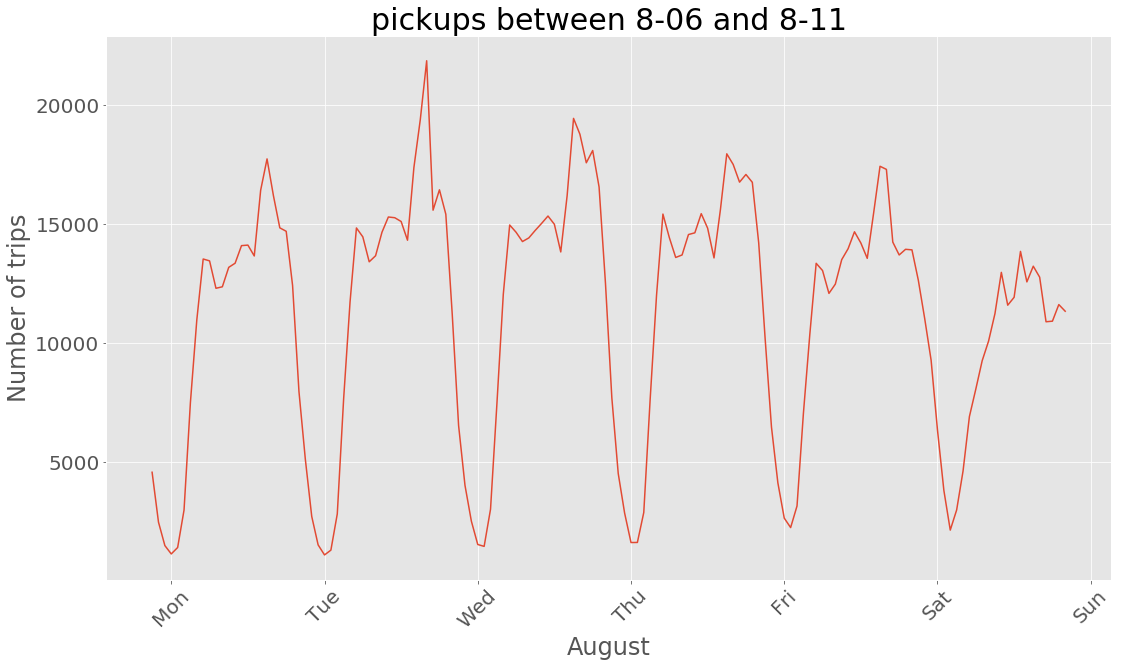

In [20]:
hourly = Aug_pickup_df.resample('H').sum()
f, ax = plt.subplots(figsize=(18,10))
plt.plot(hourly['2018-08-06':'2018-08-11'])
plt.rcParams.update({'font.size': 20})
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))
ax.set_title('pickups between 8-06 and 8-11', fontdict={'fontsize': '30', 'fontweight' : '3'})
plt.xticks(rotation=45)
plt.ylabel('Number of trips')
plt.xlabel('August')
plt.show()

Again there appears to be a daily trend in which the volume builds up in the morning and then peaks during evening rush hour and then goes back down at night.

Finally let's look at the number of trips on several days worth of 24 hour cycles. As we can see below with more granularity the volume starts at 8:00am, peaks right after 5:00pm, and finally starts to die down after 8:00pm.

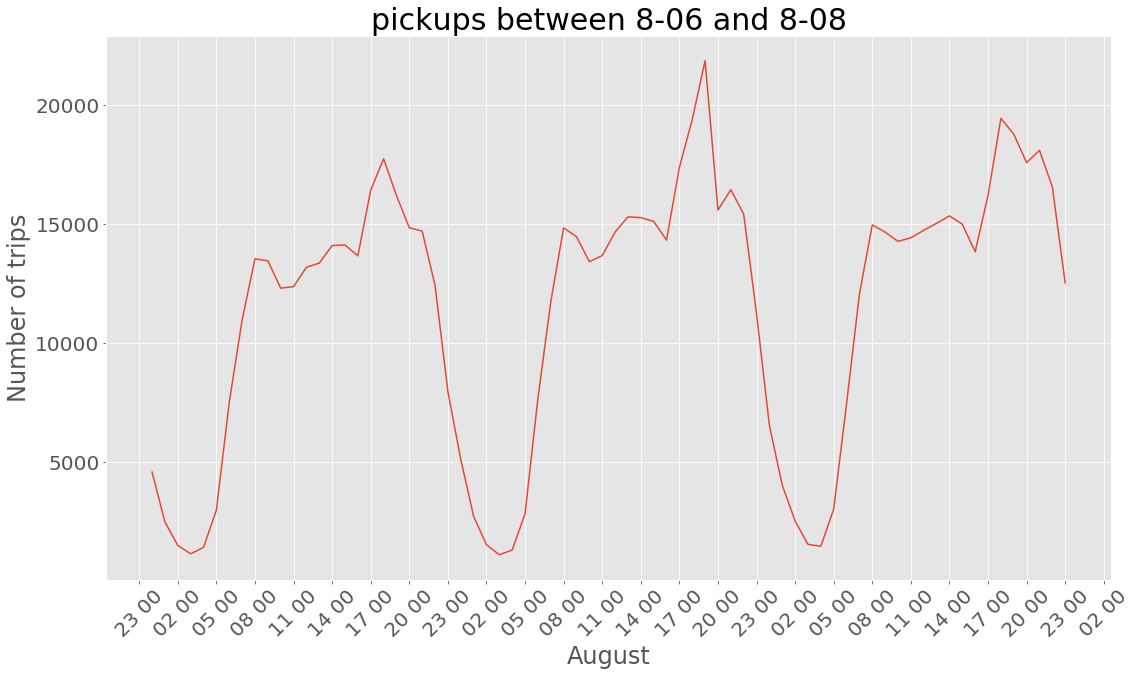

In [21]:
hourly = Aug_pickup_df.resample('H').sum()
f, ax = plt.subplots(figsize=(18,10))
plt.plot(hourly['2018-08-06':'2018-08-08'])
plt.rcParams.update({'font.size': 20})
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H %M'))
ax.set_title('pickups between 8-06 and 8-08', fontdict={'fontsize': '30', 'fontweight' : '3'})
plt.xticks(rotation=45)
plt.ylabel('Number of trips')
plt.xlabel('August')
plt.show()

# Distribution of total costs

How much do people pay on average for a taxi, and how are these amounts distributed. Below I will analyze total cost for the taxis throughout the month of August.

In [22]:
#reset and rename the data because I made the index for the Aug dataframe the date
Aug_2 = pd.read_csv(Aug_data); Aug_2.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-08-01 00:44:35,2018-08-01 01:03:22,1,5.6,1,N,238,79,1,19.0,0.5,0.5,4.00,0.0,0.3,24.30
1,1,2018-08-01 00:02:19,2018-08-01 00:02:31,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80
2,1,2018-08-01 00:13:25,2018-08-01 00:24:40,1,2.9,1,N,138,7,1,11.5,0.5,0.5,2.55,0.0,0.3,15.35
3,1,2018-08-01 00:10:37,2018-08-01 00:49:10,1,8.4,1,N,231,7,1,30.0,0.5,0.5,7.80,0.0,0.3,39.10
4,1,2018-08-01 00:02:18,2018-08-01 00:07:32,2,0.7,1,N,79,148,1,5.5,0.5,0.5,0.00,0.0,0.3,6.80


In [60]:
#let's look at some descriptive statistics as it relates to total trip cost

Aug_2_tot_amt = Aug_2['total_amount']

print('the mean is %f' %Aug_2_tot_amt.mean())
print('the median is %f' %Aug_2_tot_amt.median())
print('the standard deviation is %f' %Aug_2_tot_amt.std())
print('the max value is %d' %Aug_2_tot_amt.max())
print('the min value is %d' %Aug_2_tot_amt.min())
print('the total count is %d' %Aug_2_tot_amt.count())

the mean is 16.607458
the median is 11.800000
the standard deviation is 358.566334
the max value is 907071
the min value is -400
the total count is 7849134


After looking at August data and calculating some descriptive statistics the average total price paid for a trip in a yellow cab is about 16.60 the median value is 11.80. Since the median is a lower value than the mean the data has a positive skew. 

The max and min values are 907,071 and -400. 

In [67]:
Aug_2_sorted = Aug_2[(Aug_2['total_amount'] >= -20) & (Aug_2['total_amount'] <= 200)]; Aug_2_sorted.head()
Aug_2_sorted['total_amount'].head()

0    24.30
1     3.80
2    15.35
3    39.10
4     6.80
Name: total_amount, dtype: float64

In [70]:
removed = Aug_2_tot_amt.count() - Aug_2_sorted['total_amount'].count()

print('the mean is %f' %Aug_2_sorted['total_amount'].mean())
print('the median is %f' %Aug_2_sorted['total_amount'].median())
print('the standard deviation is %f' %Aug_2_sorted['total_amount'].std())
print('the max value is %d' %Aug_2_sorted['total_amount'].max())
print('the min value is %d' %Aug_2_sorted['total_amount'].min())
print('the total count is %d' %Aug_2_sorted['total_amount'].count())
print('a total of %d samples were removed' %removed)

the mean is 16.390482
the median is 11.800000
the standard deviation is 14.057464
the max value is 200
the min value is -19
the total count is 7846926
a total of 2208 samples were removed


It was difficult to visualize the full dataset because the max value was way beyond the majority of the data. I am not sure if someone paid a taxi driver $900k for a ride but to get a visualization down in a histogram I cut off anything higher than 200 and lower than -20. In total there were 2208 samples removed from the data when I did this. Below I plot the histogram to show the data. 

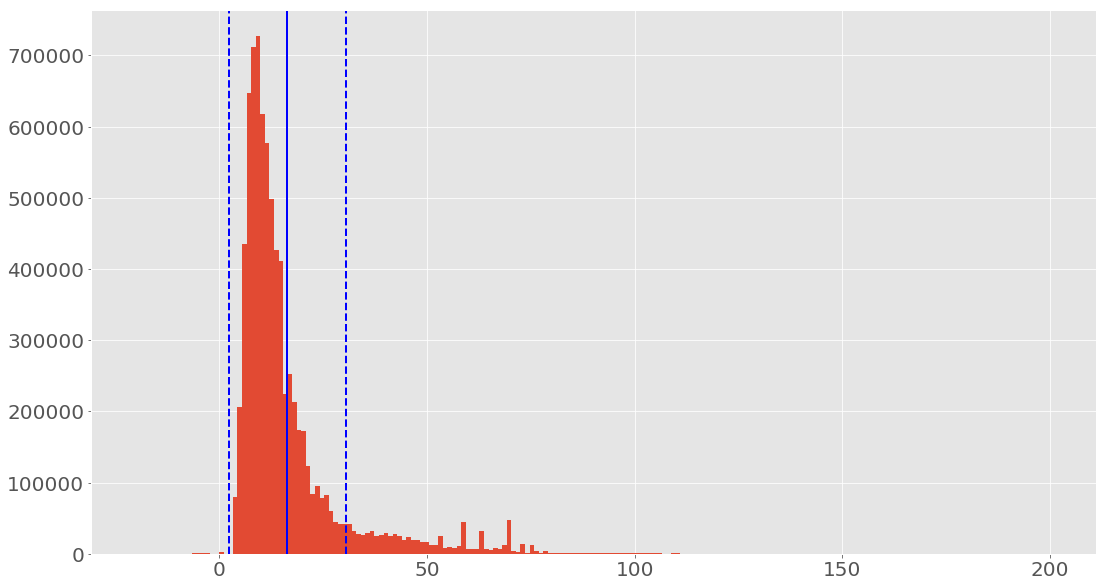

In [71]:
#plot distribution of total cost

f, ax = plt.subplots(figsize=(18,10))
plt.hist(Aug_2_sorted['total_amount'], bins=200)
plt.axvline(Aug_2_sorted['total_amount'].mean(), color='b', linestyle='solid', linewidth=2)
plt.axvline(Aug_2_sorted['total_amount'].mean()+Aug_2_sorted['total_amount'].std(), color='b', linestyle='dashed', linewidth=2)
plt.axvline(Aug_2_sorted['total_amount'].mean()-Aug_2_sorted['total_amount'].std(), color='b', linestyle='dashed', linewidth=2) 

plt.show()

From the plot of the data we can see that it is skewed positively just like the median and mean showed in the first analysis. The standard deviation dropped signifcantly when took out the extreme outliers. 

# Future Work

Overall more work can be done to explore relationship between cost and location and time and location. Specifically, it would be interesting to see what the fares would be on average for certain times of the day. Do people pay more during rush hour on average or do they pay more in the evening. Additionally, location certainly plays a role in total cost of payment.

Another interesting way of analyzing this dataset would be to look at where are the taxi rides going. For example where do most taxi rides begin and where do they end? Does time of day matter? Does the rush hour traffic in the morning originate from a certain location and get dropped-off in another location? This could be served by creating a network diagram and visualizing pickups and dropoffs.

Since this data only digs into August more work will be needed to see if different seasons affect price and location. Even more interesting would be to see if weather, such as historical precipitation percentage affects taxi cab usage. 

Further can we use this data to predict future demand and allocate resources appropriately. I suspect that veteran taxi drivers have an intuition where they should be at certain times of day, and this data 